In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

In [2]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))






In [3]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70
--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70


/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected//cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
(100, 100, 100)


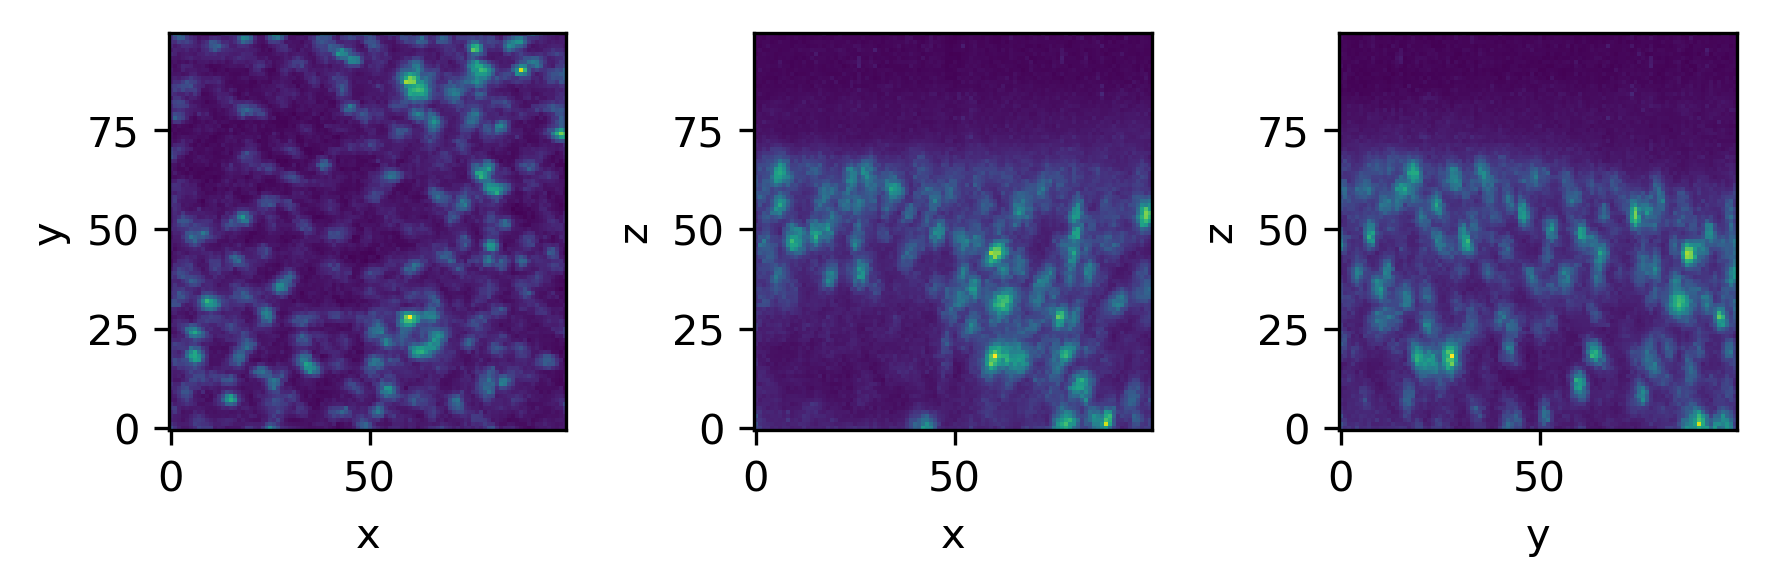

(100, 100, 100)


In [11]:
# as a test:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)
print(latticeMovieFrame.shape)

In [179]:
# read the raw csv data for further processing

trackId = 226

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]

trackData = data[data['trackId'] == trackId]
track = Track.Track(trackData)

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/trackedFeaturesProcessed.csv


# draw box

In [180]:
# this is a cube as a mesh

def getCubeMeshIndexes(cubeSize = 5, center=[0,0,0]):
# this is 5 on each side of the center
#center=np.array([224.29615185,362.37867407,45.60376889])
    indexes = []
    limits = np.array([-cubeSize,+cubeSize])
    for i in range(limits[0]-2,limits[1]+2):
        for j in  range(limits[0]-2,limits[1]+2):
            for k in range(limits[0]-2,limits[1]+2):
                value = 0
                if i in (limits+center[0]) and j in (limits+center[1]) and ((k > (limits+center[2])[0]) and (k < (limits+center[2])[1])) :
    #                print(limits+centerOfImage[0]+coord[0])
    #                print(limits+centerOfImage[1]+coord[1])
                    indexes.append([i,j,k])
                if j in limits+center[1] and k in limits+center[2] and ((i > (limits+center[0])[0]) and (i < (limits+center[0])[1])) :
                    indexes.append([i,j,k])
                if k in limits+center[2] and i in limits+center[0] and ((j > (limits+center[1])[0]) and (j < (limits+center[1])[1])) :
                    indexes.append([i,j,k])
    return(indexes)

In [181]:
outputPath = outputDataFolder+'/tracks_chimeraX/trackId_'+str(track.id)
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

trackCoords = track.m_coords
imageSize = latticeMovieFrame.shape # this is the output from cropping by 20
#newCenterOfImage = center # the center of mass of the track

#centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])





for i in range(0,movieLength):
    frameId = i+1
    image = np.zeros(imageSize)
    
    #print a box if the track is present in this frame, otherwise, draw an empty image
    if frameId in track.frameId:
        print(frameId)
        #boxCenter = trackCoords[i]
        #boxCenter = np.array([trackCoords[i][2],trackCoords[i][1],trackCoords[i][0]])-np.array([1,1,1])
        boxCenter = np.array([np.absolute(trackCoords[i][2]-imageSize[0]),trackCoords[i][1],trackCoords[i][0]])#-np.array([1,1,1])

        
    
        meshIndexes = getCubeMeshIndexes()
        meshIndexesAdjusted = meshIndexes+boxCenter.astype(int)

        for index in meshIndexesAdjusted:
            #print(index)
            #print('index',index)
            image[index[0],index[1],index[2]]=10
        

    data = image.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    #print(data.shape, data.dtype, metadata['microscope'])
    metadata = json.dumps(metadata)
    #print(metadata)
    
    outputFilename = outputPath+'/track_'+str(trackId)+'_uncropped_box_master_'+str(i)+'_frame'+str(frameId)+'.tif'
    print(outputFilename)
    skimage.external.tifffile.imsave(outputFilename, data, description=metadata)

print('done')

1
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_0_frame1.tif
2
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_1_frame2.tif
3
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_2_frame3.tif
4
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_3_frame4.tif
5
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_4_frame5.tif
6
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_55_frame56.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_56_frame57.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_57_frame58.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_58_frame59.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_59_frame60.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/tr

In [182]:
# deprecated

In [167]:
outputPath = outputDataFolder+'/tracks_chimeraX/trackId_'+str(track.id)
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

trackCoords = track.m_coords
imageSize = latticeMovieFrame.shape # this is the output from cropping by 20
#newCenterOfImage = center # the center of mass of the track

#centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])





for i in range(0,track.len):
    frameId = track.frameId[i]
    if(frameId != None):
        

        
        #boxCenter = trackCoords[i]
        #boxCenter = np.array([trackCoords[i][2],trackCoords[i][1],trackCoords[i][0]])-np.array([1,1,1])
        boxCenter = np.array([np.absolute(trackCoords[i][2]-100),trackCoords[i][1],trackCoords[i][0]])-np.array([1,1,1])

        image = np.zeros(imageSize)
    
        meshIndexes = getCubeMeshIndexes()
        meshIndexesAdjusted = meshIndexes+boxCenter.astype(int)

        for index in meshIndexesAdjusted:
            #print(index)
            #print('index',index)
            image[index[0],index[1],index[2]]=10
        
        #print(image)
        
        data = image.astype('uint16')
        metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
        #print(data.shape, data.dtype, metadata['microscope'])
        metadata = json.dumps(metadata)
        #print(metadata)
        
        outputFilename = outputPath+'/track_'+str(trackId)+'_uncropped_box_master_'+str(i)+'_frame'+str(frameId)+'.tif'
        print(outputFilename)
        skimage.external.tifffile.imsave(outputFilename, data, description=metadata)

print('done')

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_0_frame1.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_1_frame2.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_2_frame3.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_3_frame4.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_uncropped_box_master_4_frame5.tif
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/tracks_chimeraX/trackId_226/track_226_un